## Notebook for poliastro propagation tests
This notebook was created to test the poliastro propagation algorithms before including them to the digital twin framework

In [1]:
import copy

from numba import njit as jit
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

from astropy.time import Time, TimeDelta
from astropy import units as u

from poliastro.bodies import Earth
from poliastro.constants import rho0_earth, H0_earth, J2000
from poliastro.core.elements import rv2coe
from poliastro.core.perturbations import (
    atmospheric_drag_exponential,
    J2_perturbation,
    atmospheric_drag,
)
from poliastro.core.propagation import func_twobody
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import CowellPropagator
from poliastro.twobody.sampling import EpochsArray
from poliastro.util import norm
from poliastro.earth.atmosphere import COESA76

In [2]:
# EARTH CONSTANTS
earth_R = Earth.R.to(u.km)  # Earth's radius (km)
k = Earth.k.to(u.km**3 / u.s**2)  # GM constant for earth

# CHESS PATHFINDER 1 ORBITAL PARAMETERS
attractor = Earth
alt = 550 * u.km
inc = 97.59254364 * u.deg
a = earth_R + alt
ecc = 0.0 * u.one  # Circular orbit
raan = 0.0 * u.deg
argp = 0.0 * u.deg
nu = 0.0 * u.deg

# EARTH ATMOSPHERE CONSTANTS for the simple exponential atmosphere model
rho0 = rho0_earth.to(u.kg / u.km**3)  # (kg/km^3)
H0 = H0_earth.to(u.km)  # (km)

# COMPLEX ATMOSPHERIC MODEL
atmosphere_model = COESA76()
rho = atmosphere_model.density(alt).to(u.kg / u.km**3)
use_complex_model = True  # Use complex atmospheric model for now

# SPACECRAFT CONSTANTS
C_D = (
    2.2 * u.one
)  # Dimentionless drag coefficient () => constant approximation for LEO satellites
cross_section_area = 0.07487e-6 * u.km**2  # claculated average
mass = 5.284 * u.kg
A_over_m = ((cross_section_area) / (mass)).to_value(u.km**2 / u.kg) * (u.km**2 / u.kg)
B = C_D * A_over_m  # Approximation of the ballistic coefficient
print(A_over_m)

# TIME INITIALIZATION AND UNITS
unit = u.s
delta_t_val = 1 * unit
delta_t = TimeDelta(delta_t_val)
init_time_local = 0 * unit

duration_sim = 2 * u.h  # Sidereal year, 365.25 day
n_timesteps = int(duration_sim.to_value(unit) / delta_t_val.value)
end_time_local = (n_timesteps * delta_t_val.value) * unit

# epoch = J2000 # Moment in time used as reference point
epoch = Time("2027-11-01 12:00:00.000", format="iso", scale="utc")
init_time = init_time_local + epoch
end_time = end_time_local + epoch

print("Init time (local): ", init_time_local)
print("End time (local): ", end_time_local)
print("Init time (global): ", init_time.to_value("iso"))
print("End time (global): ", end_time.to_value("iso"))

file_name = "1day.npy"

1.4169190007570021e-08 km2 / kg
Init time (local):  0.0 s
End time (local):  7200.0 s
Init time (global):  2027-11-01 12:00:00.000
End time (global):  2027-11-01 14:00:00.000


In [3]:
# Function for general plotting in 2d
def plot_1d(
    x,
    y,
    title,
    xlabel,
    ylabel,
    step=1,
    fill_under=True,
    remove_box=True,
    x_range=None,
    y_range=None,
    scatter=False,
    x_label_f=None,
    custom_y_ticks=False,
    y_ticks=None,
    y_tick_labels=None,
    custom_x_ticks=False,
    x_ticks=None,
    x_tick_labels=None,
    save_filename=None,
    show=True,
):
    # Downsample the x and y arrays
    x_downsampled = x[::step]
    y_downsampled = y[::step]

    # Create the plot
    plt.figure(figsize=(6, 4))
    if scatter:
        plt.scatter(x_downsampled, y_downsampled, marker=".", color="blue")
    else:
        plt.plot(x_downsampled, y_downsampled, marker=".", linestyle="-", color="blue")

    # Beautifying the plot
    plt.title(title, fontsize=13, fontweight="medium")
    plt.xlabel(xlabel, fontsize=11)
    plt.ylabel(ylabel, fontsize=11)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Setting x and y axis ranges if provided
    if x_range is not None:
        plt.xlim(x_range)  # Set the x-axis range (tuple)
    if y_range is not None:
        plt.ylim(y_range)  # Set the y-axis range (tuple)

    # Adding customizations
    ax = plt.gca()  # Get the current axis
    if x_label_f is not None:
        ax.xaxis.set_major_formatter(FuncFormatter(x_label_f))
    if custom_y_ticks:
        if y_ticks is None or y_tick_labels is None:
            raise ValueError("Must provide y ticks and y tick labels")
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_tick_labels)
    if custom_x_ticks:
        if x_ticks is None or x_tick_labels is None:
            raise ValueError("Must provide x ticks and x tick labels")
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_tick_labels)
    if fill_under:
        plt.fill_between(x_downsampled, y_downsampled, color="lightblue", alpha=0.3)
    if remove_box:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        # Remove ticks
        ax.yaxis.set_ticks_position("none")
        ax.xaxis.set_ticks_position("none")
    else:
        ax.spines["top"].set_color((0.8, 0.8, 0.8))
        ax.spines["right"].set_color((0.8, 0.8, 0.8))
        ax.spines["left"].set_color((0.8, 0.8, 0.8))
        ax.spines["bottom"].set_color((0.8, 0.8, 0.8))

    # Show the plot
    plt.tight_layout()
    if save_filename is not None:
        plt.savefig(save_filename)
    if show:
        plt.show()
    else:
        plt.close()


# Function to convert seconds to days to change label of x axis
def seconds_to_days(x, pos):
    """Convert seconds to days."""
    return f"{x / 86400:.0f}"

In [4]:
# Define orbit, time units and number of timesteps
orbit = Orbit.heliosynchronous(
    attractor=attractor,
    a=a,
    ecc=ecc,
    # inc = inc,
    raan=raan,
    argp=argp,
    nu=nu,
    epoch=epoch,  # will convert to tdb (Barycentric dynamical time)
)
print("Orbital Period:", orbit.period)
print("Orbit characteristics:", orbit)


# Perturbation added due to J2 effect and atmospheric drag
@jit  # Add @jit for speed!
def a_d(t0, state, k, J2, R, C_D, A_over_m, H0, rho0, rho, complex_model=False):
    if complex_model:
        return J2_perturbation(t0, state, k, J2, R) + atmospheric_drag(
            t0, state, k, C_D, A_over_m, rho
        )
    else:
        return J2_perturbation(t0, state, k, J2, R) + atmospheric_drag_exponential(
            t0, state, k, R, C_D, A_over_m, H0, rho0
        )


def f(t0, state, k):
    du_kep = func_twobody(t0, state, k)
    ax, ay, az = a_d(
        t0,
        state,
        k,
        J2=Earth.J2.value,
        R=earth_R.value,
        C_D=C_D.value,
        A_over_m=A_over_m.value,
        H0=H0.value,
        rho0=rho0.value,
        rho=rho.value,
        complex_model=use_complex_model,  # which atmospheric model to use?
    )
    du_ad = np.array([0, 0, 0, ax, ay, az])

    return du_kep + du_ad


# Special case: only J2
def f_J2(t0, state, k):
    du_kep = func_twobody(t0, state, k)
    ax, ay, az = J2_perturbation(t0, state, k, J2=Earth.J2.value, R=earth_R.value)
    du_ad = np.array([0, 0, 0, ax, ay, az])

    return du_kep + du_ad


# Special case: only drag
def f_drag(t0, state, k):
    du_kep = func_twobody(t0, state, k)
    ax, ay, az = atmospheric_drag_exponential(
        t0,
        state,
        k,
        R=earth_R.value,
        C_D=C_D.value,
        A_over_m=A_over_m.value,
        H0=H0.value,
        rho0=rho0.value,
    )
    du_ad = np.array([0, 0, 0, ax, ay, az])

    return du_kep + du_ad

Orbital Period: 5738.992317998695 s
Orbit characteristics: 6928 x 6928 km x 97.6 deg (GCRS) orbit around Earth (♁) at epoch 2027-11-01 12:01:09.183 (TDB)


## Propagation loops
Propagation can be done in 2 ways:
- With the Ephem class, giving the initial, end time and number of timesteps. Accelerated method which doesn't allow to call user-defined functions at every timestep
- With a for loop: slower but enables to call functions at every timestep (hence update the subsytems)

In [5]:
tofs = TimeDelta(
    np.linspace(init_time_local, end_time_local, num=n_timesteps + 1)
)  # gives the results in days

In [6]:
# # First way
# rr_ephem, vv_ephem = orbit.to_ephem(
#     EpochsArray(orbit.epoch + tofs, method=CowellPropagator(f=f)),
# ).rv()

# altitudes = norm(rr_ephem, axis=1) - earth_R
# radius = norm(rr_ephem, axis=1)
# # Not used, here for reference

In [7]:
# Second way

# Cowell propagator
orbit_cowell = copy.deepcopy(orbit)

eph_cowell = np.zeros((n_timesteps + 1, 6))
eph_cowell[0, :3] = orbit_cowell.r
eph_cowell[0, 3:] = orbit_cowell.v

# Main for loop of the propagation
for t in range(0, n_timesteps):
    orbit_cowell = orbit_cowell.propagate(delta_t, method=CowellPropagator(f=f))
    eph_cowell[t + 1, :3] = orbit_cowell.r
    eph_cowell[t + 1, 3:] = orbit_cowell.v

# Extract the data
altitudes_cowell = np.linalg.norm(eph_cowell, axis=1) - earth_R.value
rr = eph_cowell[:, :3]
vv = eph_cowell[:, 3:]
orbital_params = np.array([rv2coe(k, r, v) for r, v in zip(rr, vv)])
ps = orbital_params[:, 0]
eccs = orbital_params[:, 1]
incs = orbital_params[:, 2]
raans = orbital_params[:, 3]
argps = orbital_params[:, 4]
nus = orbital_params[:, 5]
a_s = np.divide(
    ps, 1 - np.multiply(eccs, eccs)
)  # Formula linking semi-latus rectum to semi-major axis

In [8]:
# save trajectory in file for notebook "plotting.ipynb"
np.save("propagation_results/position_vel_" + file_name, eph_cowell)

epochs_array = np.array(orbit.epoch + tofs)
np.save("propagation_results/epochs_" + file_name, epochs_array)

print(eph_cowell.shape)
print(epochs_array.shape)

(7201, 6)
(7201,)


Change in altitude: 7.270621261325687


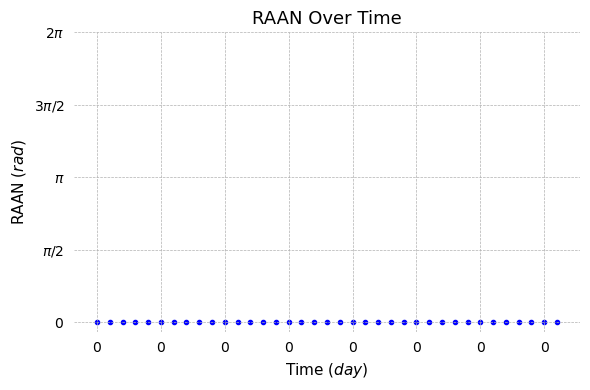

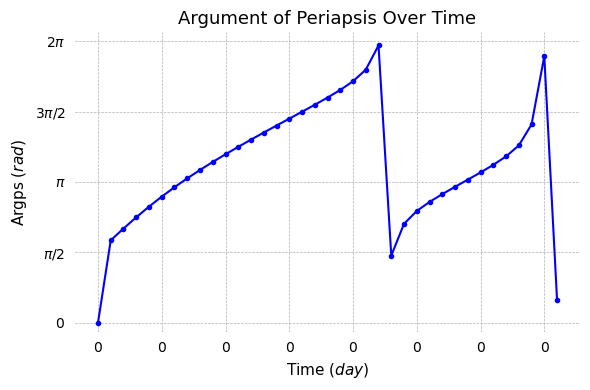

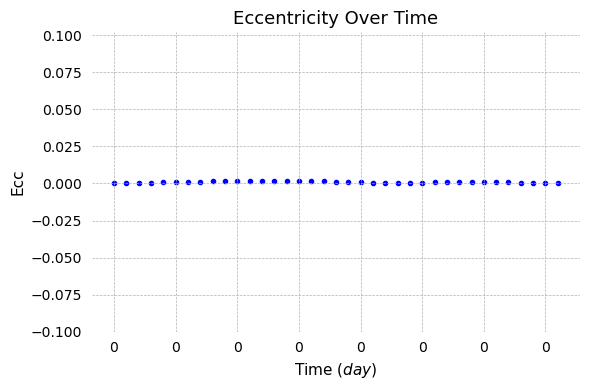

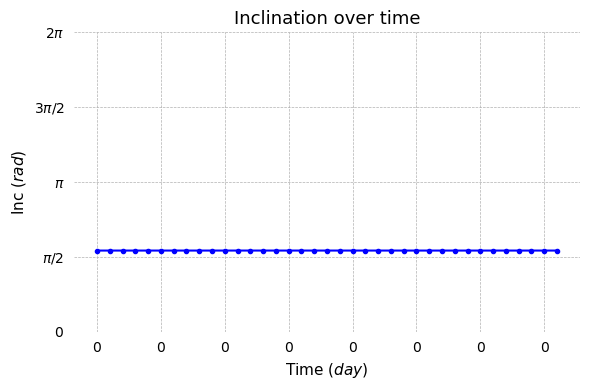

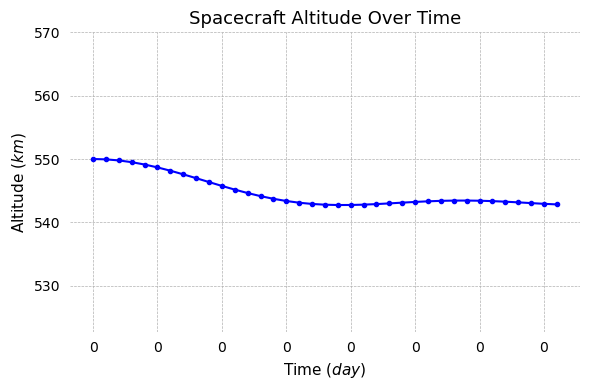

In [23]:
print("Change in altitude:", (np.max(altitudes_cowell) - np.min(altitudes_cowell)))

ticks_angle = np.array([0, 1 / 2 * np.pi, np.pi, 3 / 2 * np.pi, 2 * np.pi])
tick_labels_angle = np.array([r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"])
plot_1d(
    tofs.to_value("second"),
    raans,
    "RAAN Over Time",
    r"Time ($day$)",
    r"RAAN ($rad$)",
    step=100,
    fill_under=False,
    remove_box=True,
    y_range=(min(raans) - 0.2, max(raans) + 0.2),
    scatter=True,
    custom_y_ticks=True,
    y_ticks=ticks_angle,
    y_tick_labels=tick_labels_angle,
    x_label_f=seconds_to_days,
    save_filename="propagation_results/RAAN.png",
)

plot_1d(
    tofs.to_value("second"),
    argps,
    "Argument of Periapsis Over Time",
    r"Time ($day$)",
    r"Argps ($rad$)",
    step=100,
    fill_under=False,
    remove_box=True,
    y_range=(min(argps) - 0.2, max(argps) + 0.2),
    custom_y_ticks=True,
    y_ticks=ticks_angle,
    y_tick_labels=tick_labels_angle,
    x_label_f=seconds_to_days,
    save_filename="propagation_results/argp.png",
)

plot_1d(
    tofs.to_value("second"),
    eccs,
    "Eccentricity Over Time",
    r"Time ($day$)",
    r"Ecc",
    step=100,
    fill_under=False,
    remove_box=True,
    y_range=(min(eccs) - 0.1, max(eccs) + 0.1),
    scatter=True,
    x_label_f=seconds_to_days,
    save_filename="propagation_results/ecc.png",
)

plot_1d(
    tofs.to_value("second"),
    incs,
    "Inclination over time",
    r"Time ($day$)",
    r"Inc ($rad$)",
    step=100,
    fill_under=False,
    remove_box=True,
    y_range=(min(incs) - 0.2, max(incs) + 0.2),
    custom_y_ticks=True,
    y_ticks=ticks_angle,
    y_tick_labels=tick_labels_angle,
    x_label_f=seconds_to_days,
    save_filename="propagation_results/inc.png",
)

plot_1d(
    tofs.to_value("second"),
    altitudes_cowell,
    "Spacecraft Altitude Over Time",
    r"Time ($day$)",
    r"Altitude ($km$)",
    step=100,
    fill_under=False,
    remove_box=True,
    y_range=(min(altitudes_cowell) - 20, max(altitudes_cowell) + 20),
    x_label_f=seconds_to_days,
    save_filename="propagation_results/altitude.png",
)